##### INSTALLED

In [2]:
# pip install --upgrade google-cloud-vision

### Step 1 - import libraries

In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import io
import os

# Imports the Google Cloud client library
from google.cloud import vision
from google.cloud.vision import types

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [92]:
# Code Reference From: https://github.com/googleapis/google-cloud-python/issues/5349
# need this in order to access API - enter your JSON file in the path after you have created your service account

from google.oauth2 import service_account
credentials = service_account.Credentials. from_service_account_file("./flood-car-classifier-3de49495f20b.json")

### Step 2 - Read in image directories as lists

In [78]:
flood = []
for i in os.listdir('data/images_for_labeling/flood'):
    if i == '.DS_Store' or i == '.ipynb_checkpoints':
        pass
    else:
        flood.append(i)
        
noflood = []
for i in os.listdir('data/images_for_labeling/no_flood'):
    if i == '.DS_Store' or i == '.ipynb_checkpoints':
        pass
    else:
        noflood.append(i)

### Step 3 - Create function to detect labels and return 10 words which best describe the pictures from the flood and no_flood lists created in step 2

In [162]:
# formula inspired by https://cloud.google.com/vision/docs/labels

# enter_list_name - list must be named exactly as it is in filepath for function to work

def image_labeler(enter_list_name, flood_or_noflood_string):
    
    # Create dictionary for image filename & image labels
    image_dict = {}
    
    for file in enter_list_name:
    
        # Instantiates a client
        client = vision.ImageAnnotatorClient(credentials=credentials)

        # The name of the image file to annotate
        file_name = os.path.abspath('./data/images_for_labeling/' + flood_or_noflood_string + '/' + file)

        # Loads the image into memory
        with io.open(file_name, 'rb') as image_file:
            content = image_file.read()

        image = types.Image(content=content)

        # Performs label detection on the image file
        response = client.label_detection(image=image)
        labels = response.label_annotations
        
        # Create list of image labels
        image_list = []
        
        # Loop through each images assigned labels
        for label in labels:
            image_list.append(label.description)
        
        # Add image filename & labels to dictionary
        image_dict[flood_or_noflood_string + '__' +file] = image_list
        
        # Create DF from results
        image_df = pd.DataFrame(image_dict.items(), columns=['filename', 'labels'])
        image_df['flood_in_image'] = str(enter_list_name)
        
        # Create Y target Column
        if flood_or_noflood_string == 'flood':
            image_df['flood_in_image'] = 1
        elif flood_or_noflood_string == 'noflood':
            image_df['flood_in_image'] = 0
        
        # Prepare X column for pre-processing
        image_df['labels'] = image_df['labels'].apply(lambda x: ", ".join(x).lower())
        
    return image_df

In [163]:
flood_df = image_labeler(flood, 'flood')
flood_df.head()

,filename,labels,flood_in_image
0,flood__flood_64.jpg,"land vehicle, vehicle, car, city car, compact ...",1
1,flood__flood_70.jpg,"water, vehicle, reflection, rain, car, puddle,...",1
2,flood__flood_58.jpg,"land vehicle, vehicle, car, automotive design,...",1
3,flood__flood_103.jpg,"vehicle, car, compact car, supermini, crossove...",1
4,flood__flood_117.jpg,"vehicle, car, waterway, flood, water resources...",1


In [164]:
noflood_df = image_labeler(noflood, 'noflood')
noflood_df.head()

,filename,labels,flood_in_image
0,noflood__no_flood_94.jpg,"land vehicle, vehicle, car, luxury vehicle, au...",0
1,noflood__no_flood_102.jpg,"land vehicle, vehicle, car, motor vehicle, aut...",0
2,noflood__no_flood_80.jpg,"land vehicle, vehicle, car, motor vehicle, min...",0
3,noflood__no_flood_57.jpg,"land vehicle, vehicle, car, motor vehicle, aut...",0
4,noflood__no_flood_43.jpg,"land vehicle, vehicle, tire, car, automotive t...",0


### Step 4 - Combine Flood & No Flood DFs into one dataframe

In [165]:
def combine_df(dataframe1, dataframe2):
    df = pd.concat([dataframe1, dataframe2], axis=0).reset_index().drop(columns='index')
    return df

In [166]:
df = combine_df(flood_df, noflood_df)
print(df.shape)
df.head()

(229, 3)


,filename,labels,flood_in_image
0,flood__flood_64.jpg,"land vehicle, vehicle, car, city car, compact ...",1
1,flood__flood_70.jpg,"water, vehicle, reflection, rain, car, puddle,...",1
2,flood__flood_58.jpg,"land vehicle, vehicle, car, automotive design,...",1
3,flood__flood_103.jpg,"vehicle, car, compact car, supermini, crossove...",1
4,flood__flood_117.jpg,"vehicle, car, waterway, flood, water resources...",1


In [168]:
df.to_csv('./data/step_1_data.csv')
print(df.shape)
df.head()

(229, 3)


,filename,labels,flood_in_image
0,flood__flood_64.jpg,"land vehicle, vehicle, car, city car, compact ...",1
1,flood__flood_70.jpg,"water, vehicle, reflection, rain, car, puddle,...",1
2,flood__flood_58.jpg,"land vehicle, vehicle, car, automotive design,...",1
3,flood__flood_103.jpg,"vehicle, car, compact car, supermini, crossove...",1
4,flood__flood_117.jpg,"vehicle, car, waterway, flood, water resources...",1


### Which Model Should I Use?
<img src="https://scikit-learn.org/stable/_static/ml_map.png">

In [169]:
X = df.labels
y = df.flood_in_image

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=2020)

In [171]:
cvec = CountVectorizer()
Z_train = cvec.fit_transform(X_train)
Z_test = cvec.transform(X_test)

In [172]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(Z_train, y_train)

# This is how we evaluate model performance
print(f'Cross Validation Score: {cross_val_score(LogisticRegression(), Z_train, y_train, cv=5).mean()}')

print(f'Training Score: {logreg.score(Z_train, y_train)}')
print(f'Testing Score: {logreg.score(Z_test, y_test)}')

Cross Validation Score: 0.8769747899159663
Training Score: 0.9707602339181286
Testing Score: 0.8103448275862069


In [138]:
# LinearSVC
svc = LinearSVC()
svc.fit(Z_train, y_train)

# This is how we evaluate model performance
print(f'Cross Validation Score: {cross_val_score(LinearSVC(), Z_train, y_train, cv=5).mean()}')

print(f'Training Score: {svc.score(Z_train, y_train)}')
print(f'Testing Score: {svc.score(Z_test, y_test)}')

Cross Validation Score: 0.8539495798319328
Training Score: 1.0
Testing Score: 0.7586206896551724


In [208]:
# MultinomialNB
mnb = MultinomialNB()
mnb.fit(Z_train, y_train)

# This is how we evaluate model performance
print(f'Cross Validation Score: {cross_val_score(MultinomialNB(), Z_train, y_train, cv=5).mean()}')

print(f'Training Score: {mnb.score(Z_train, y_train)}')
print(f'Testing Score: {mnb.score(Z_test, y_test)}')

Cross Validation Score: 0.8536134453781511
Training Score: 0.8947368421052632
Testing Score: 0.8793103448275862


In [174]:
# Baseline
df.flood_in_image.value_counts(normalize=True)

1    0.541485
0    0.458515
Name: flood_in_image, dtype: float64

In [175]:
# Predictions
y_pred = mnb.predict(Z_test)
y_pred

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0])

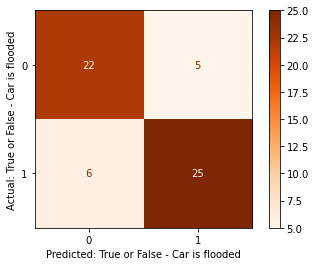

In [176]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Plot
plot_confusion_matrix(logreg, Z_test, y_test, cmap='Oranges', values_format='d');
plt.xlabel('Predicted: True or False - Car is flooded')
plt.ylabel('Actual: True or False - Car is flooded');

In [177]:
# FOR VERIFICATION AND INTERPRETABILITY OF ABOVE
print('False'.center(40, "-"))
print(f'(0,0) True Negative - {tn}')
print(f'(0,1) False Positive - {fp}')
print('True'.center(40, "-"))
print(f'(1,0) False Negative - {fn}')
print(f'(1,1) True Positive - {tp}')

-----------------False------------------
(0,0) True Negative - 26
(0,1) False Positive - 1
------------------True------------------
(1,0) False Negative - 6
(1,1) True Positive - 25


In [178]:
# Model Prediction
print(f'Model Predicted Score: {(tn + tp) / (tn + tp + fn + fp)}')
print()

# Calculate the specificity
spec = tn / (tn + fp)
print(f'Specificity: {spec} - (0) Correctly Predicted NO FLOODING / ALL NO FlOODING images')
print()

# Sensitivity
sens = tp / (tp + fn)
print(F'Sensitivity: {sens} - (1) Correctly Predicted FLOODING / ALL FlOODING images')
print()

# Precision
prec = tp / (tp + fp)
print(f'Precision: {prec} - (1) Correctly Predicted FLOODING / ALL FlOODING predictions')


Model Predicted Score: 0.8793103448275862

Specificity: 0.9629629629629629 - (0) Correctly Predicted NO FLOODING / ALL NO FlOODING images

Sensitivity: 0.8064516129032258 - (1) Correctly Predicted FLOODING / ALL FlOODING images

Precision: 0.9615384615384616 - (1) Correctly Predicted FLOODING / ALL FlOODING predictions


In [209]:
# # Set Up Pipes
# lr_pipe = Pipeline([
#     ('cv', CountVectorizer()),
#     ('logreg', LogisticRegression(solver='liblinear', random_state=2020)),
# ])

# mnb_pipe = Pipeline([
#     ('cv', CountVectorizer()),
#     ('mnb', MultinomialNB()),
# ])
# svc_pipe = Pipeline([
#     ('cv', CountVectorizer()),
#     ('svc', LinearSVC(random_state=2020)),
# ])

In [210]:
# # Set Up Params
# lr_pipe.get_params()
# lr_pipe_params = {
#     'cv__max_df': [1.0],
#     'cv__max_features': [None],
#     'cv__min_df': [1],
#     'cv__ngram_range': [(1, 1)],
#     'logreg__C': [1.0],
#     'logreg__class_weight': [None],
#     'logreg__max_iter': [100],
# #     'logreg__solver': ['lbfgs'],  
# }

# mnb_pipe.get_params()
# mnb_pipe_params = {
#     'cv__max_df': [1.0],
#     'cv__max_features': [None],
#     'cv__min_df': [1],
#     'cv__ngram_range': [(1, 1)],
#     'mnb__alpha': [1.0, 0.1, 0.01, .0001],
# }

# svc_pipe.get_params()
# svc_pipe_params = {
#     'cv__max_df': [1.0],
#     'cv__max_features': [None],
#     'cv__min_df': [1],
#     'cv__ngram_range': [(1, 1)],
#     'svc__C': [1.0],
#     'svc__class_weight': [None],
# }

In [211]:
# # gridsearch
# # gs_lr = GridSearchCV(lr_pipe, lr_pipe_params, n_jobs = -1, cv = 5, verbose = 2)
# # gs_lr.fit(X_train, y_train)

# gs_mnb = GridSearchCV(mnb_pipe, mnb_pipe_params, n_jobs = -1, cv = 5, verbose = 2)
# gs_mnb.fit(X_train, y_train)

# # gs_svc = GridSearchCV(svc_pipe, svc_pipe_params, n_jobs = -1, cv = 5, verbose = 2)
# # gs_svc.fit(X_train, y_train)